# Visualization of some statistic data

### import libraries

In [64]:
import pandas as pd
from time import time
import matplotlib.pyplot as plt
import seaborn as sns

### Read dataframe

In [65]:
df = pd.read_csv('slam_articles_with_country.csv')
df = df.dropna(subset=['country'])

## plot the number of publications by year

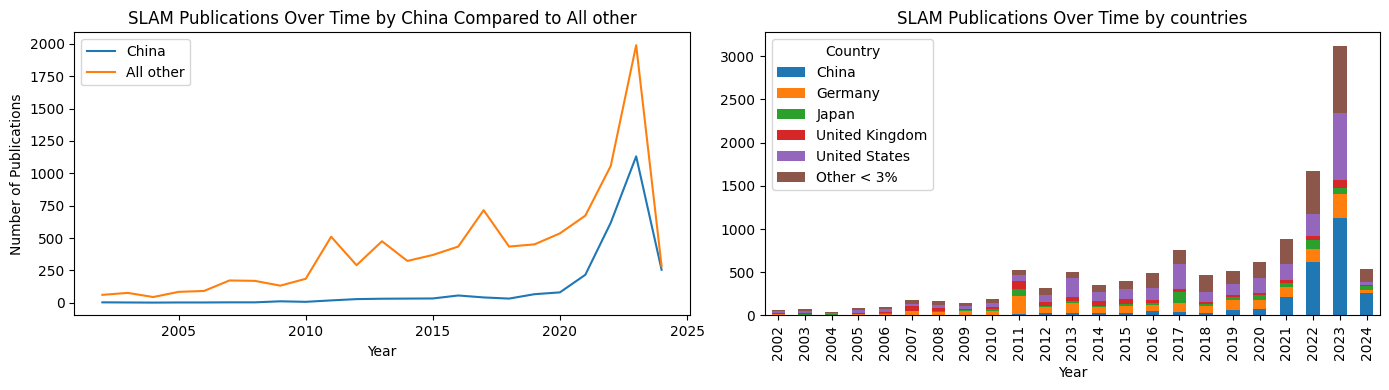

In [66]:
#----------------------------------
trh_percent = 3

copy_df = df.copy()

# Calculate the percentage of entries for each country
country_counts = copy_df['country'].value_counts(normalize=True) * 100

small_countries = country_counts[country_counts < trh_percent].index
copy_df['country_adjusted'] = copy_df['country'].apply(lambda x: f'Other < {trh_percent}%' if x in small_countries else x)

agg_data_adjusted = copy_df.groupby(['year', 'country_adjusted']).size().unstack(fill_value=0)

if f'Other < {trh_percent}%' in agg_data_adjusted.columns:
    cols = [col for col in agg_data_adjusted if col != f'Other < {trh_percent}%'] + [f'Other < {trh_percent}%']
    agg_data_adjusted = agg_data_adjusted[cols]

#---------
# Plotting
#---------
china_yearly = df[df['country'] == 'China'].groupby('year').size()
other_yearly = df[df['country'] != 'China'].groupby('year').size()

fig, ax = plt.subplots(1,2,figsize=(14,4))
ax[0].plot(china_yearly.index, china_yearly.values, label='China')
ax[0].plot(other_yearly.index, other_yearly.values, label='All other')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Number of Publications')
ax[0].set_title('SLAM Publications Over Time by China Compared to All other')
ax[0].legend()
#----------------------------------
agg_data_adjusted.plot(kind='bar', stacked=True, ax=ax[1])
ax[1].set_title('SLAM Publications Over Time by countries')
ax[1].set_xlabel('Year')
ax[1].legend(title='Country')

plt.tight_layout()
plt.show()

The graph shows that China only started actively publishing from 2021 onwards.  
However, during this time, China has begun to make a significant contribution to SLAM research.

## Percentage of publications by countries over the last years

In [81]:
def print_stat(dataframe, text):
    country_counts = dataframe['country'].value_counts(normalize=True) * 100
    print_shift =20
    print(f"Percentage of Publications by Country Over the {text}:")
    cum_sum = 0
    for i, (country, val) in enumerate(country_counts.items()):
        cum_sum += val
        print(f"{i}) {country}:{" "*(print_shift -len(country))}{val:.1f}%")
        if i == 5:
            print('-'*(print_shift//2))
            print("Other:"," "*(print_shift-2), f"{(100-cum_sum):.1f}%", sep='')
            break

since_year = 2014
dataframe = df[(df['year'] >= since_year)]
print_stat(dataframe, f"Last {2024 - since_year} Years")
print()

year = 2018
dataframe = df[(df['year'] == year)]
print_stat(dataframe, f"{year} Year")
print()

year = 2023
dataframe = df[(df['year'] == year)]
print_stat(dataframe, f"{year} Year")

Percentage of Publications by Country Over the Last 10 Years:
0) China:               26.1%
1) United States:       23.9%
2) Germany:             12.1%
3) Japan:               5.9%
4) United Kingdom:      4.1%
5) Singapore:           3.4%
----------
Other:                  24.6%

Percentage of Publications by Country Over the 2018 Year:
0) United States:       26.4%
1) Germany:             16.5%
2) China:               6.9%
3) Canada:              6.7%
4) Japan:               5.8%
5) Singapore:           3.6%
----------
Other:                  34.1%

Percentage of Publications by Country Over the 2023 Year:
0) China:               36.2%
1) United States:       25.2%
2) Germany:             8.9%
3) Singapore:           3.2%
4) United Kingdom:      2.7%
5) South Korea:         2.6%
----------
Other:                  21.3%


The data shows that China and the United States lead the way in the number of publications,  
with China increasing significantly from 6.9% in the last 6 years to 36.2% in 2023.  

## plot h-index for countries by year
The h-index is defined as the maximum value of h such that the given author/journal has published at least h papers that have each been cited at least h times.

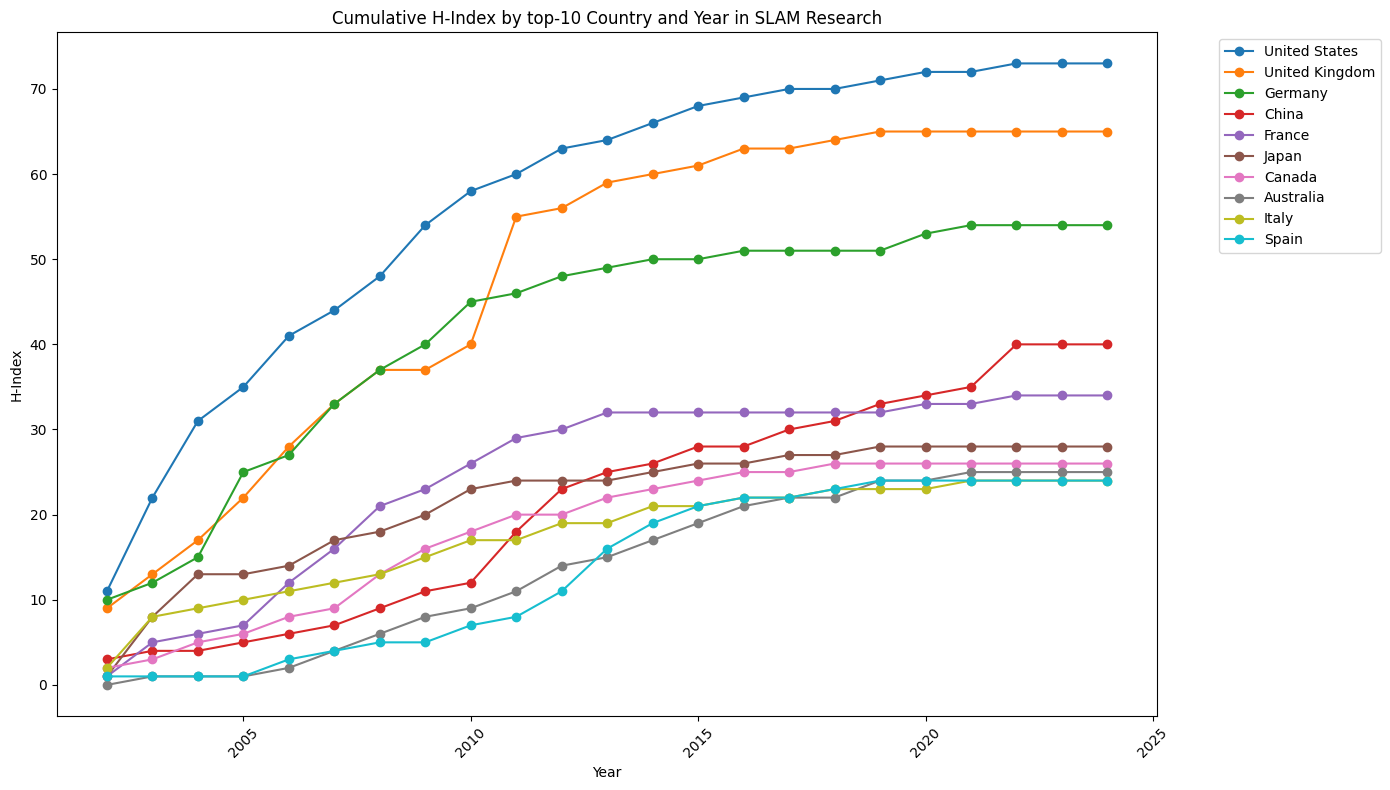

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

top_N = 10

def calculate_h_index(citations):
    return sum(x >= i + 1 for i, x in enumerate(sorted(list(citations), reverse=True)))

copy_df = df.dropna(subset=['country','is-referenced-by-count'])

# Prepare the data: for each country, for each year, include all articles up to that year
country_list = copy_df['country'].unique()
year_list = sorted(copy_df['year'].unique())
h_indices = {c:{} for c in country_list}

for country in copy_df['country'].unique():
    country_data = copy_df[copy_df['country'] == country]
    for year in year_list:
        citations = country_data[country_data['year'] <= year]['is-referenced-by-count'].tolist()
        h_indices[country][year] = calculate_h_index(citations)

latest_h_indices = {country: h_indices[country][year_list[-1]] for country in h_indices}
top_N_countries = sorted(latest_h_indices, key=latest_h_indices.get, reverse=True)[:top_N]

# Plotting
plt.figure(figsize=(14, 8))

for country in top_N_countries:
    idx = [h_indices[country][year] for year in year_list]
    plt.plot(year_list, idx, label=country, marker='o')

plt.xlabel('Year')
plt.ylabel('H-Index')
plt.title(f'Cumulative H-Index by top-{top_N} Country and Year in SLAM Research')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


However, China has a rather low h-index on the large increase in publications and the dominance of their number of publications.  
This may indicate the unpopularity of Chinese papers, which may be influenced by their poor quality.

Against the background of China, it can be noted that the UK and Germany, while not having a large lead in the number of publications, surprisingly have a high level of h-index.

## plot i10-index for countries by year
The i-10 index indicates the number of academic publications an author has written that have been cited by at least 10 sources.

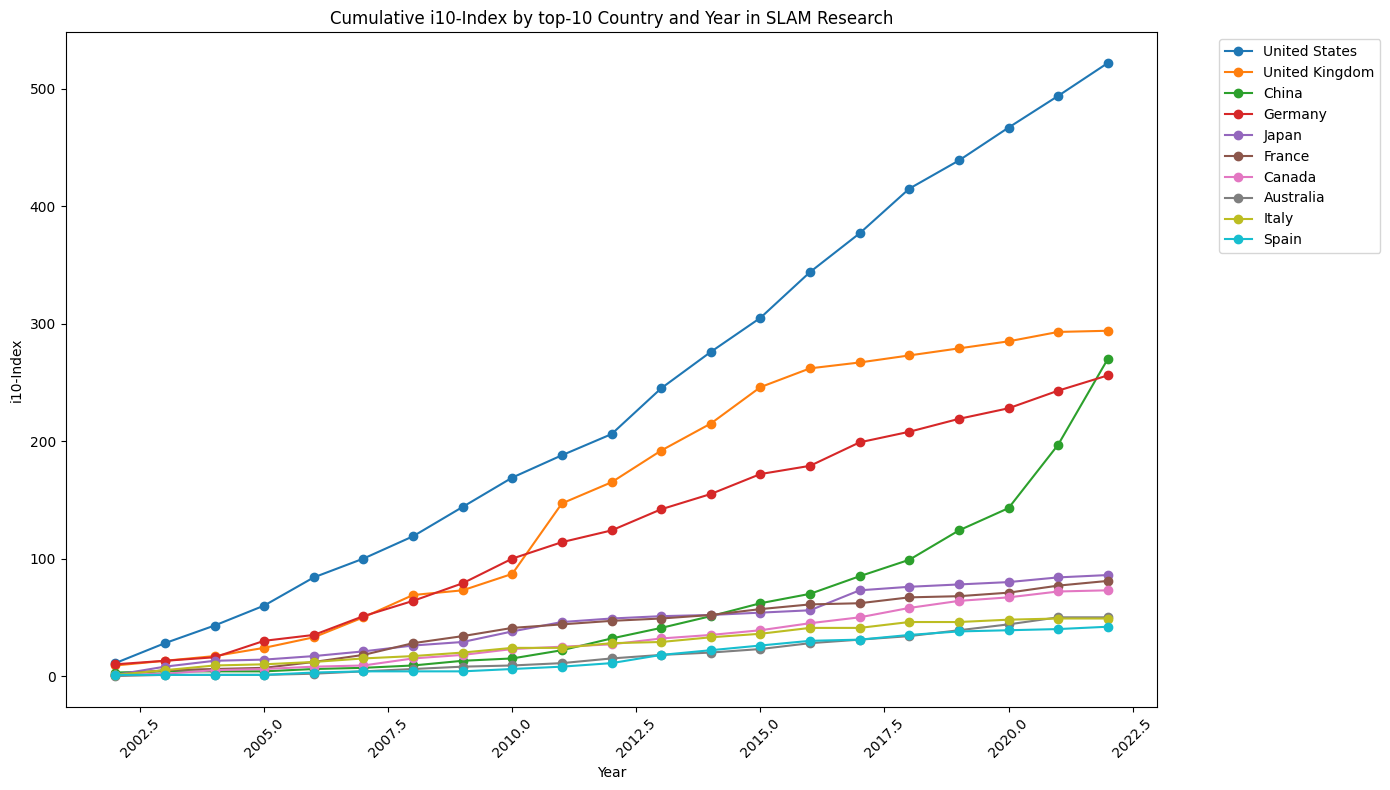

In [73]:
import pandas as pd
import matplotlib.pyplot as plt

top_N = 10

copy_df = df.dropna(subset=['country','is-referenced-by-count'])
copy_df = copy_df[copy_df['is-referenced-by-count'] >= 10]

# Prepare the data: for each country, for each year, include all articles up to that year
country_list = copy_df['country'].unique()
year_list = sorted(copy_df['year'].unique())
year_list = year_list[:-1] # skip last year
i10_indices = {}

for country in copy_df['country'].unique():
    country_data = copy_df[copy_df['country'] == country]
    i10_indices[country] = {year:len(country_data[country_data['year'] <= year]) for year in year_list}

latest_i10_indices = {country: i10_indices[country][year_list[-1]] for country in i10_indices}
top_N_countries = sorted(latest_i10_indices, key=latest_i10_indices.get, reverse=True)[:top_N]

# Plotting
plt.figure(figsize=(14, 8))

for country in top_N_countries:
    idx = [i10_indices[country][year] for year in year_list]
    plt.plot(year_list, idx, label=country, marker='o')

plt.xlabel('Year')
plt.ylabel('i10-Index')
plt.title(f'Cumulative i10-Index by top-{top_N} Country and Year in SLAM Research')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


From the graph, we can see a rapid increase in the number of Chinese papers with more than 10 publications, indicating great potential going forward.

According to this criterion, we can notice the leadership of 4 countries: USA, China, UK, Germany.  
However, among them only USA and China show good growth.

## Conclusion

Over the past 5 years, China has significantly increased from 6.9% in 2018 to 36.2% in 2023 of the total publications in this field, becoming the leader in the number of publications. 
However, in other criteria such as h-index and i10-index, the USA remains the leader. China, meanwhile, shows the highest growth in these criteria.